# Bayesian Approach to Error-in-Variables Regression with Python and emcee

# <span style="color:#7D1935">1. Introduction</span>

As with many braches of science, regression is a fundamental aspect of data analysis in astronomy and astrophysics. It has long been known that various regression methods can produce biased results, and the "best" approach to regression has long been sought (eg. [Pearson 1901](http://stat.smmu.edu.cn/history/pearson1901.pdf)). In recent years, there has been a proliferation of articles in the astronomy and astrophysics literature providing useful advice on regression in data analysis. Here I list several recent and very useful examples, given in chronological order:

* [D'Agostini 2005   -- "*Fits, and especially linear fits, with errors on both axes, extra variance of the data points and other complications*"](http://arxiv.org/abs/physics/0511182)
* [Kelly 2007        -- "*Some Aspects of Measurement Error in Linear Regression of Astronomical Data*"](http://arxiv.org/abs/0705.2774)
* [Hogg et al. 2010  -- "*Data analysis recipes: Fitting a model to data*"](http://arxiv.org/abs/1008.4686)
* [Andreon 2011      -- "*Understanding better (some) astronomical data using Bayesian methods*"](http://arxiv.org/abs/1112.3652)
* [Andreon 2012      -- "*Measurement errors and scaling relations in astrophysics: a review*"](http://arxiv.org/abs/1210.6232)
* [Robotham & Obreschkow 2015 -- "*Hyper-Fit: Fitting Multidimensional Data with Multivariate Gaussian Uncertainties*"](http://quantumholism.com/wp-content/papercite-data/pdf/robotham2015.pdf)


To summarise much of the advice from the above articles, a hierarchical Bayesian approach is often preferred using a so-called "error-in-variables" model: a kind of hierarchical framework that is aimed at dealing with uncertainties in the independent as well as dependent variables, as well as intrinsic scatter in the underlying regression relation. This is sometimes referred to as a measurement error model, or Model II regression. 

For this type of hierarchical model, a Gibbs sampler such as JAGS is typically recommended. However, for most (simple) cases, it is straightforward to define the posterior probability distribution explicitly, in which case other samplers may be used. Many astronomers use python for their data analysis, and learning a new syntax may present a barrier for some. Here I discuss the method of Bayesian error-in-variables modelling using the popular, and very effective affine invariant MCMC ensemble sampler ["*emcee*"](http://dan.iel.fm/emcee/current/). 

This notebook is by no means a substitute for the detailed discussion in the publications listed above, or a textbook, but is an attempt to provide a simple explanation and unification of the discussion and advice in the aforementioned papers, and to demonstrate a simple implementation of Bayesian multivariate regression in Python.

***

# <span style="color:#7D1935">2. The Mathematical Basis of Bayesian Error-in-variables regression

### 2.1 Notation

* <span style="font-size:14pt;font-weight:bold">P(A)</span> 

    refers to the probability that event A will occur.


* <span style="font-size:14pt;font-weight:bold">P(A|B)</span> 

    refers to the conditional probability that event A will occur, given that event B has occurred. 
         - If events A and B are independent, then P(A|B) = P(A). 


* <span style="font-size:14pt;font-weight:bold">P(A,B)</span> 

    refers to the joint probability distribution, that is, the probability that both A and B will occur. 
         - If events A and B are independent, then P(A,B) = P(A)P(B).


### 2.2. Definition of Conditional Probability

Given two events A and B, the conditional probability of A given B is defined as:

### $P(A|B) = \frac{P(A,B)}{P(B)}$

which can be read as "The probability of event A given event B is equal to the joint probability of events A and B divided by the probability of event B." This is clearly true when events A and B are independent (see notation above). However, this expression holds even when A and B are not independent. An equivalent expression is 

### $P(A,B) = P(A|B)P(B) = P(B|A)P(A)$

In this way, the joint probability distribution P(A,B) can be specified in terms of the conditional probability P(A|B) or P(B|A).

Note that conditional probability is defined, rather than derived. The definition of conditional probability is considered by some to be an axiom of probability theory. 

### 2.3. Bayes Rule

Bayes rule follows directly from the definition of conditional probability above:

## $P(B|A) = \frac{P(A|B) P(B)}{P(A)}$

This is Bayes Rule. Equivalently 

### $P(B|A) = \frac{P(A, B)}{P(A)}$


### 2.4. Chain rule (product rule)

The chain rule, or product rule, also follows directly from the definition of conditional probability via mathematical induction. The chain rule enables a joint probability distribution to be defined using a "hierarchical" set of conditional probabilities. That is, the chain rule lets us factor a joint probability distribution into the product of many conditional probabilities which are easier to define and deal with. A joint probability distribution can be factored in many different ways.  

To demonstrate the chain rule, consider 4 events, A, B, C, D. We can factorise the joint probability distribution as follows:

### $P(A, B, C, D) = P(A | B, C, D) P(B | C, D) P(C | D) P(D)$

This same joint probability distribution can be factorised in several ways, for example, we could write

### $P(A, B, C, D) = P(B | A, C, D) P(C | A, D) P(D | A) P(A)$

The chain rule allows us to define the likelihood function (P(data | model)) in terms of the most convenient set of conditional probabilities for our particular problem. 

### 2.5. Marginalising nuisance parameters, latent variables (missing data) and hyperparameters via integration

Consider two variables X and Y, for which we know the joint probability distribution P(X,Y). We can determine the *marginal* probability distribution of X independent of Y by simply "integrating out" the variable Y. 

### $P(X) = \int_y P(X,Y)dy = \int_y P(X|Y)P(Y)dy$

The above integration is said to marginalise out the variable Y, which is often called a "nuisance parameter". 

This procedure of marginalisation allows us to include in our model additional latent variables or hyperparameters that can be marginalised out, in order to determine the probability distribution of interest. This is of particular relevance to the error-in-variables model, which I now discuss. 

***


# The Posterior Probability Distribution: The basis of Bayesian Regression. 


The ultimate goal of Bayesian statistical analysis is to determine the probability distribution of model parameters $\theta$ given that we have observed the data $(x,y)$. This is done by creating a large set of samples whose distribution closely resembles the joint **Posterior Probability Distribution** for the model parameters:

### $p(\theta$ | $x,y$)

From the posterior probability distribution, it is possible to determine the most probable (i.e. "best-fit") model parameter values, as well as their uncertainies, accounting for degeneracies in the model. 

The most important step in Bayesian analysis is to describe the posterior probability distribution for the model parameters. Hierarchical modeling allows us to build up the posterior probability distribution from a set of conditional probabilities that arise naturally from the model. 

So, ultimately, we wish to find an expression for the posterior distribution $p(\theta$ | $x,y$). From Bayes rule, this can be expressed as the product of the data likelihood $p(x,y$ | $\theta$) and the prior probability distribution for the model parameters p($\theta$)

### $p(\theta$ | $x,y$) = $\frac{p(x,y | \theta) p(\theta)}{p(x,y)}$

The probability distribution p(x,y) is called the marginal likelihood or model evidence, and it's value is independent of the model parameters. In other words, p(x,y) is determined by the data alone, and is not dependent on the model parameters. 

### $p(x,y) = \int_\theta p(\theta, x,y) p(\theta) d\theta$

Therefore, p(x,y) can be treated as a constant, and we can write

### $p(\theta$ | $x,y$) $\propto p(x,y | \theta) p(\theta) = p(x,y,\theta)$

To determine the likelihood function we require a generative model, that is, a model for how the data was generated. The error-in-variables or measurement error model does just that.

***

# <span style="color:#7D1935">3. The Error-In-Variables Regression Model</span>

Error in variables models, or measurement error models (also sometimes called type II models), are a type of regression model that account for statistical uncertainty in the independent variables. They do so by invoking latent variables to link the observed data to their "true" values - that is, the values that would have been observed had there been no measurement uncertainty. These latent variables are marginalised (integrated out), and this process accounts for the uncertainty in both dependent and independent variables.

The standard linear regression model, including intrinsic scatter, is expressed as 

### $$y^* = \alpha + \beta^T x^* + \epsilon$$ 

where $(x^*, y^*)$ are the true values of the independent and dependent variables, $(\alpha, \beta)$ are the regression coefficients and $\epsilon$ is a random variable with variance $\sigma^2$ that represents the intrinsic scatter in the relation between $x^*$ and $y^*$. Due to measurement uncertainty, we do not observe the "true" values $x^*$ and $y^*$, but rather we obtain a set of observed values that are "corrupted" by some offset. The exact value of this offset is not known, but its probability distribution is known, based on our knowledge of the uncertainty in our measuring device. This allows us to write down a relation between the observed and "true" values as follows:

### $$x_i = x_i^* + \epsilon_{x_i}$$ 
### $$y_i = y_i^* + \epsilon_{y_i}$$ 

where $(x_i, y_i)$ represent the observed independent and dependent variables, $(x_i^*, y_i^*)$ are the latent variables representing the "true" values of the data that would have been observed had there been no statistical uncertainty in the measurements, and $\epsilon_{x_i}$ and $\epsilon_{y_i}$ are random variables with known (or assumed) probability distributions. This situation is often encountered in astronomy and astrophysics. 

The vector of model parameters in this case is $\theta = (\alpha, \beta, \sigma^2)$ and the latent variables or "missing data" are  $(x^*, y^*)$.

Using the chain rule, the full joint probability distribution for the observed data and latent variables for the $i^{th}$ data point is 

### $p(x_i, y_i, x_i^*, y_i^*$, $\theta) = p(x_i,y_i$ | $x_i^*, y_i^*, \theta) ~ p(y_i^* $ | $x_i^*, \theta) ~ p(x_i^* $ | $\theta) ~ p(\theta)$

We can now marginalise the latent variables via integration to obtain the posterior probability distribution for the error-in-variables regression model



## $$p(\theta | x,y) \propto p(x, y, \theta) = \prod_{i=1}^n\int_{y_i^*} \int_{x_i^*} p(x_i,y_i | x_i^*, y_i^*, \theta) ~ p(y_i^*  | x_i^*, \theta) ~ p(x_i^*  | \theta) ~ p(\theta) dx_i^* dy_i^*$$



The above equation is the basis for all error-in-variables modeling. The first term on the RHS represents the measurement uncertainties, the second term represents the regression relation including the intrinsic scatter in the relation, the third term represents the distribution of independent variables, and the fourth term represents the prior probability distribution for the regression coefficients. I consider each of these terms greater in detail below. The aforementioned publications discussing regression in astronomy and astrophysics are effectively based on the above equation, and only differ in their approach to terms 3 and 4, as discussed below.


* <span style="font-size:14pt;font-weight:bold"> First term $p(x_i,y_i$ | $x_i^*, y_i^*, \theta)$ -- measurement uncertainties:  </span>

    Let us define the variable $z_i = (y_i, x_i)$ to specify the location of the data point i, and the associated "true" location of that data point $z_i^* = (y_i^*, x_i^*)$. Let the covariance matrix $\Sigma_i$ describe the (possibly correlated) Gaussian uncertainties in the data $z_i$. Then:
    
    $$p(z_i~ | ~z_i^*, \theta) \sim N(z_i^*, \Sigma_i) = \frac{1}{\sqrt{(2\pi)^D |\Sigma_i|}} \exp \left( -\frac{1}{2}(z_i^* - z_i)^T \Sigma_i^{-1}(z_i^* - z_i) \right) $$



*   <span style="font-size:14pt;font-weight:bold">Second term $p(y_i^*$  | $x_i^*, \theta)$ -- regression relation including intrinsic scatter: </span>
    
    From our description of the model (above) we have 

$$p(y_i^* ~ | ~x_i^*, \theta) \sim N([\alpha + \beta^T x_i^*], \sigma) = \frac{1}{\sqrt{(2\pi) \sigma^2}} \exp \left( -\frac{\left( y_i^* - (\alpha + \beta^T x_i^*) \right)^2}{2 \sigma^2} \right)$$ 
    
    
*   <span style="font-size:14pt;font-weight:bold">Third term $p(x_i^* $ | $\theta)$ -- the prior distribution of independent variables: </span>

    The distribution from which the independent varaible(s) have been drawn is generally not known, but by examining a histogram of the independent variables it is usually clear that the distribution is not uniform. The distribution of independent variables must therefore be modelled or assumed. Modelling the distribution of independent variables is the focus of Kelly 2007, who advocate the introduction of hyperparameters $\psi$ that describe this distribution. These hyperparameters are marginalised, but they account for the uncertainty in the distribution from which the independent variables are drawn. 

    For the implementation below, we assume the independent variables are drawn from a uniform distribution. This is clearly not an accurate description in most cases, but using the python implementation below, we can test the strength of the bias in the derived regression coefficients. 


*   <span style="font-size:14pt;font-weight:bold">Fourth term $p(\theta)$ -- prior probability distribution for model parameters $\theta = (\alpha, \beta, \sigma^2)$:</span>

    * Kelly 2007 adopt a uniform prior on the regression parameters ($\alpha, \beta, \sigma^2$).

    * Andreon & Hurn 2012 advocate for a Student's t distribution for the prior on regression slope, which is equivalent to a flat prior on angle between the line and the dependent variable axis (See Andreon and Hurn 2012, equation 19). They also advocate an inverse Gamma prior for the intrinsic scatter, and a Gaussian prior on the intercept. 

    * Hogg 2010, on pg. 31 states: "The only modification we would suggest is performing the fit or likelihood maximization not in distance of (m,b) but rather ($\Theta$, b$_\perp$) where $b_\perp = b \cos \Theta$ is the perpendicular distance of the line from the origin. This removes the paradox that the standard "prior" assumption on standard straight line fitting treats all slopes m equally, putting way too much attention on angles near $\pm \pi/2$. The Bayesian must set a prior. Again, there are many choices, but the most natural is something like flat in $\Theta$ and flat in $b_\perp$ (the latter not proper)."  

        It can be shown ([see here](http://www.astron.nl/~godfrey/priors_on_regression_parameters.pdf)) that uniform priors on $\Theta, b_\perp$ and $\sigma_\perp^2$ actually corresponds to (for D dimensional data) 
    
    $$p(\alpha, \beta, \sigma^2) \propto \left( 1+ \sum_{j=1}^{D-1} \beta_j^2 \right)$$ 

    * Robotham & Obreschow 2015 advocate a rotationally invariant likelihood function. Their expression is equivalent to the error-in-variables model with priors that are uniform in $\Theta, b_\perp$ and $\sigma_\perp^2$, as described immediately above. 


It is interesting to note the variety of advice that is given for the priors for regression parameters. It is also interesting to note that Kelly 2007 focus entirely on the third term, while essentially ignoring the fourth term, while others focus entirely on the fourth term, and ignore the third term.  

***

# <span style="color:#7D1935">4. Posterior probability distribution for data in 3D.</span>

If we take the equation for the posterior probability distribution and make the following assumptions:

* Gaussian measurement uncertainties, 
* Gaussian intrinsic scatter, 
* rotationally invariant priors, 
* uniform distribution of independent variables

then the posterior probability distribution can be written


$$p(\theta | x, y) \propto p(x, y, \theta) =  \prod_{i=1}^n p(\theta) \frac{1}{\sqrt{2 \pi s_i^2}} \exp \left( \frac{ \left(y_i - \alpha - \beta^Tx_i \right)^2}{2 s_i^2} \right)$$

where $$s_i^2 = \sigma^2 + \sigma_{y,i}^2 + \beta^T \Sigma_i^{-1} \beta$$

and in the simplest 3D case where the measurement uncertaintes on each dimension are independent, this reduces to

$$s_i^2 = \sigma^2 + \sigma_{y,i}^2 + \beta_{x_1,i}^2 \sigma_{x_1,i}^2 + \beta_{x_2,i}^2 \sigma_{x_2,i}^2$$

Finally, incorporating the rotationally invariant priors $p(\theta)$ ([see here](http://www.astron.nl/~godfrey/priors_on_regression_parameters.pdf)), we have

$$p(x, y, \theta) =  \prod_{i=1}^n \left( 1 + \beta_{x_1}^2 + \beta_{x_2}^2 \right)^{1/2} \frac{1}{\sqrt{2 \pi s_i^2}} \exp \left( \frac{ \left(y_i - \alpha - \beta^Tx_i \right)^2}{2 s_i^2} \right)$$

and the natural log is given by

$$\ln[p(x,y,\theta)] = \frac{1}{2} \sum_i \left[ \ln \left( \frac{ \left( 1+\beta_{x_1}^2 + \beta_{x_2}^2 \right)}{s^2_{y, i}} \right)  - \frac{( \beta^T x_i + \alpha - y_i )^2}{s_{y,i}^2} \right]$$ 

Note that this is the same as the likelihood function given by [Robotham & Obreschkow 2015](http://quantumholism.com/wp-content/papercite-data/pdf/robotham2015.pdf).

***


# 5. <span style="color:#7D1935">Implementation Using Emcee</span>


Whilst it could be argued that PyMC or JAGS may be more appropriate for this situation, here I use emcee, which allows (requires!) an explicit description of the conditional probability distribution from which we will sample to obtain the posterior distribution of model parameters. This explicit implementation is useful for educational purposes. 

## 5.1. Set up the environment ##

In [1]:
from __future__ import print_function

import sys
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize as opt
import emcee
import triangle
from IPython.display import display, Math, Latex

Allow plots 'in-line'

In [2]:
%matplotlib inline

## 5.2. Generate fake data 

In [3]:
# Set the size of the fake dataset

N_obs = 50

# Set the regression coefficients and intrinsic scatter in the relation

alpha = 1.0
beta1 = 0.4
beta2 = 0.8
sigma = 0.3
sigma_squared = sigma**2

# Set the measurement uncertainties on the independent and dependent variables

sigma_x_1 = 0.3
sigma_x_2 = 0.3
sigma_y = 0.3

# Now, generate the independent variables from a multivariate normal 
# (Note that in our regression model, we are assuming that these have been selected from a uniform distribution,
#  which is clearly incorrect. This will allow us to test the importance of the third term in the posterior 
#  distribution - that is, the prior distribution of independent variables, which is the focus of Kelly 2007))

mean = [0.0, 0.0]
cov = [[0.5,2.0],[2.0,0.5]]

x_true = np.random.multivariate_normal(mean,cov,N_obs).T

# Now generate the y-axis data from the regression model and the independent variables

y_true = alpha + beta1*x_true[0] + beta2*x_true[1] + np.random.normal(0.0,sigma,size=N_obs)

# Now add measurement uncertainties to obtain an "observed" dataset

x_1_obs = x_true[0] + np.random.normal(0.0, sigma_x_1, size=N_obs)

x_2_obs = x_true[1] + np.random.normal(0.0, sigma_x_2, size=N_obs)

y_obs = y_true + np.random.normal(0.0, sigma_y, size=N_obs)

## 5.3. Visualise the data

In order to visualise the interdependence of the three variables, we can plot the data through different slices, coloring each point by it's value of the third variable. 

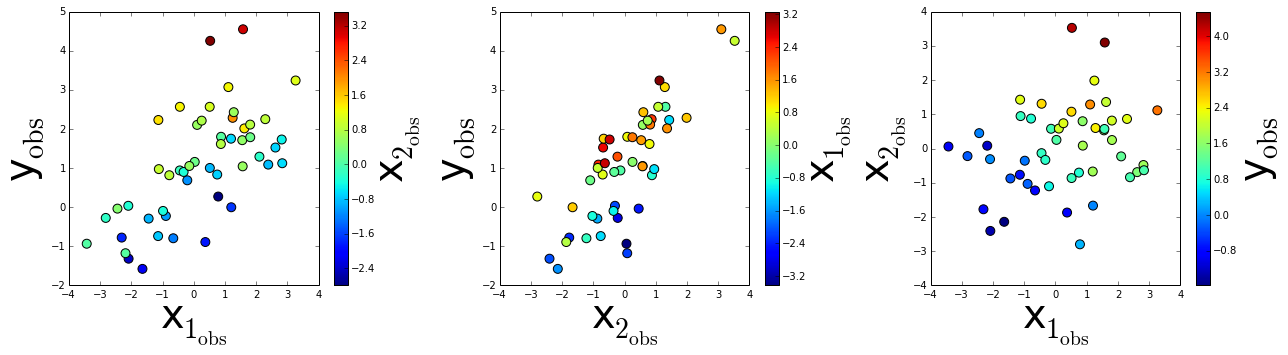

In [4]:
    
    x_1_obs_label = r"x$_{1_{\rm obs}}$"    
    x_2_obs_label = r"x$_{2_{\rm obs}}$"
    y_obs_label = r"y$_{\rm obs}$"
    fntsz = 40
    
    
    plt.figure(figsize=(18,5))
    
    plt.subplot(1,3,1)
    plt.scatter(x_1_obs, y_obs, c=x_2_obs, marker='o', s=80)
    cbar = plt.colorbar()
    plt.xlabel(x_1_obs_label, fontsize=fntsz)
    plt.ylabel(y_obs_label, fontsize=fntsz)
    cbar.set_label(x_2_obs_label, fontsize=fntsz)
    
    plt.subplot(1,3,2)
    plt.scatter(x_2_obs, y_obs, c=x_1_obs, marker='o', s=80)
    cbar = plt.colorbar()
    plt.xlabel(x_2_obs_label, fontsize=fntsz)
    plt.ylabel(y_obs_label, fontsize=fntsz)
    cbar.set_label(x_1_obs_label, fontsize=fntsz)

    plt.subplot(1,3,3)
    plt.scatter(x_1_obs, x_2_obs, c=y_obs, marker='o', s=80)
    cbar = plt.colorbar()
    plt.xlabel(x_1_obs_label, fontsize=fntsz)
    plt.ylabel(x_2_obs_label, fontsize=fntsz)
    cbar.set_label(y_obs_label, fontsize=fntsz)

    plt.tight_layout()
    
    plt.show()

## 5.4. Specify the Model

### That is, define log probability function from which emcee will sample

Now we need to define the joint probability distribution from which emcee will take samples. This is done by decomposing into log-prior, log-likelihood, and log-probability functions:


In [5]:
Model_parameter_names = [r"$\alpha$", r"$\beta_1$", r"$\beta_2$", r"$\sigma^2$"]

#-----------------------------------------------------------------------------#
def lnprior(p):
    # The parameters are stored as a vector of values, so unpack them
    alpha,beta1,beta2,sigma_sq = p
    # We're using only uniform priors, and only eps has a lower bound
    if sigma_sq <= 0:
        return -np.inf
    return 0.5*np.log((1.0 + beta1**2 + beta2**2))


#-----------------------------------------------------------------------------#
def lnlike(p, x_1, x_2, y, sigma_x_1, sigma_x_2, sigma_y):
    alpha,beta1,beta2,sigma_sq = p
    model = alpha + beta1*x_1 + beta2*x_2
    
    denom = sigma_sq + sigma_y**2 + (beta1*sigma_x_1)**2 + (beta2*sigma_x_2)**2
    
    lp = -0.5*np.sum((y - model)**2/denom + np.log(denom) + np.log(2.0*np.pi))
    
    return lp


#-----------------------------------------------------------------------------#
def lnprob(p, x_1, x_2, y, sigma_x_1, sigma_x_2, sigma_y):
    lp = lnprior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(p, x_1, x_2, y, sigma_x_1, sigma_x_2, sigma_y)

#-----------------------------------------------------------------------------#

## 5.5. Set up the emcee sampler

In [6]:
nWalker = 50
nDim = 4
nThreads = 4
nSteps = 1000
nBurnSteps = 250

Initialise the walkers of the emcee sampler, with random offsets around some "guesses"

In [7]:
p_initial_guesses = [1.5, 0.8, 0.3, 0.2]
p0 = [(p_initial_guesses + 0.01*np.random.rand(nDim)) for i in range(nWalker)]

Define an emcee sampler object. Multiprocessing is built in, so we can take advantage of multiple CPU's to run the walkers in parallel using nThreads.

In [8]:
sampler = emcee.EnsembleSampler(nWalker,nDim,lnprob, args=(x_1_obs,x_2_obs,y_obs, sigma_x_1, sigma_x_2, sigma_y), threads=nThreads)

## 5.6. Run a 'burn-in' phase for the sampler.

In [9]:
pos, prob, state = sampler.run_mcmc(p0, nBurnSteps, storechain=True)

Now plot the resulting walkers

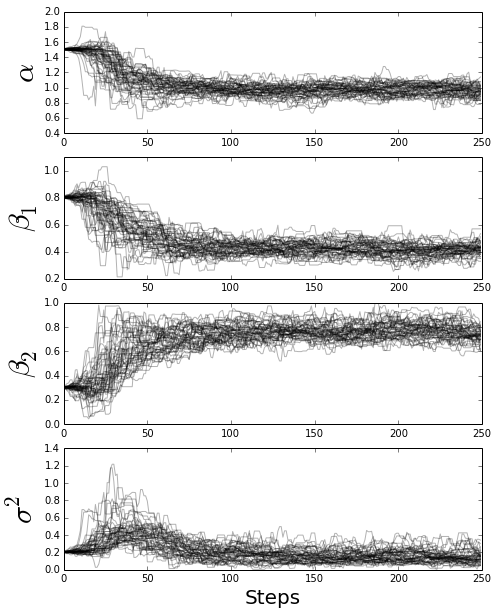

In [11]:
fig1 = plt.figure(figsize=(7.5, 10))
for j in range(nDim):
    ax = fig1.add_subplot(nDim,1,j+1)
    ax.plot(np.array([sampler.chain[:,i,j] for i in range(nBurnSteps)]), 'k', alpha = 0.3)
    ax.set_ylabel(Model_parameter_names[j], fontsize = 30)
plt.xlabel('Steps', fontsize = 20)
fig1.show()


## 5.7. Run the sampler *'for reals!'*

In [12]:
sampler.reset()
sampler.run_mcmc(pos, nSteps, storechain=True);

Now plot the resulting walkers

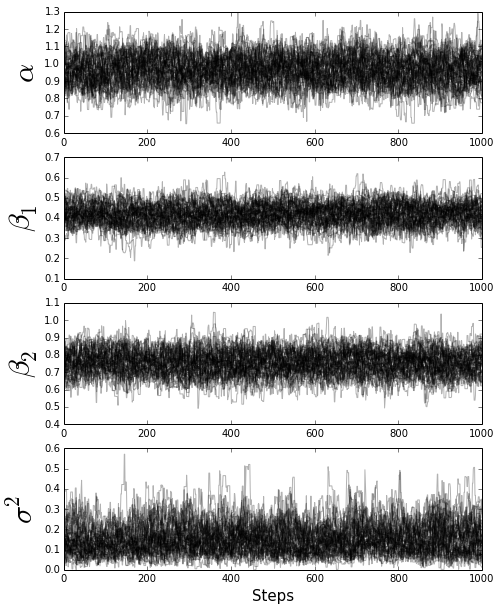

In [13]:
fig2 = plt.figure(figsize=(7.5, 10))
for j in range(nDim):
    ax = fig2.add_subplot(nDim,1,j+1)
    ax.plot(np.array([sampler.chain[:,i,j] for i in range(nSteps)]), 'k', alpha = 0.3)
    ax.set_ylabel(Model_parameter_names[j], fontsize = 30)
plt.xlabel('Steps', fontsize = 15)
fig2.show()

## 5.8. Plot the results using "triangle"

As well as chain, the sampler has a flatchain attribute which simply concatenates all the walkers' chains into one. So the array shape will be (nSteps $\times$ nWalkers, nDim). We can now compute the medians and plot the results of the model.

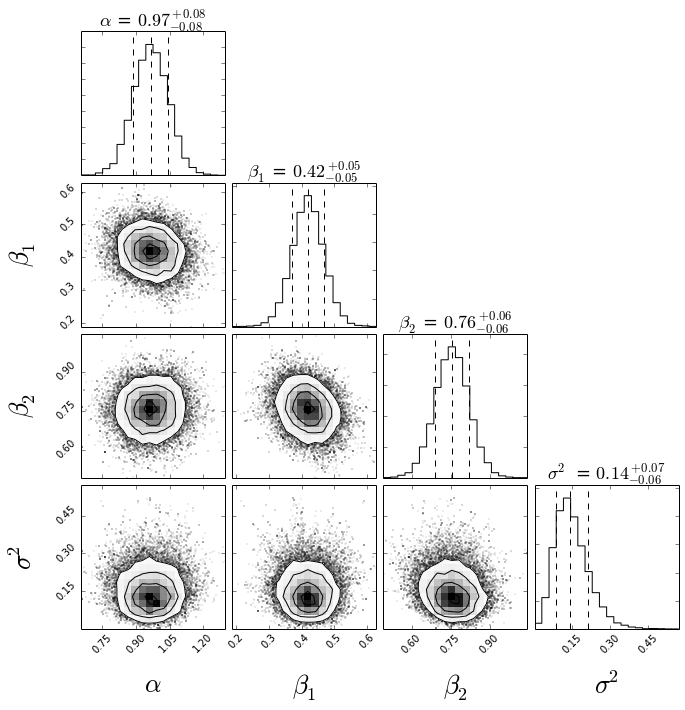

In [14]:
figure = triangle.corner(sampler.flatchain, labels=[Model_parameter_names[0],Model_parameter_names[1],Model_parameter_names[2],Model_parameter_names[3]], quantiles=[0.16, 0.5, 0.84], label_kwargs={'fontsize': 26}, show_titles=True, title_kwargs={'size': 18})

plt.savefig("triangle_plot_cavities_1400MHz.pdf", format="pdf")

plt.show()



## 5.9. Get "best-fit" values 
### Well, actually, get the median and 90% confidence regions for the posterior distributions.

In [19]:
# Calculate best-fit parameter values from the sampled posterior probability distributions

params = [r"\alpha", r"\beta_1", r"\beta_2", r"\sigma^2"]
true_vals = [str(alpha), str(beta1), str(beta2), str(sigma_squared)]
medians = np.zeros(nDim)

print("True : Fitted")

percentiles = [10, 50, 90]

for i in range(nDim):
    qvalues = np.percentile(sampler.flatchain[:,i], percentiles)
    medians[i] = qvalues[1]
    delta_upper = qvalues[2] - qvalues[1]
    delta_lower = qvalues[1] - qvalues[0]
    
    # Format the quantile display.
         
    result_fmt=".2f"
    fmt = "{{0:{0}}}".format(result_fmt).format
    result = r"{{{0}}}_{{-{1}}}^{{+{2}}}"
    result = result.format(fmt(qvalues[1]), fmt(delta_upper), fmt(delta_lower))
 
    display(Math(params[i] + " = " + true_vals[i] + " : " + params[i] + "=" + result))

True : Fitted


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## 5.10. Plot the fits

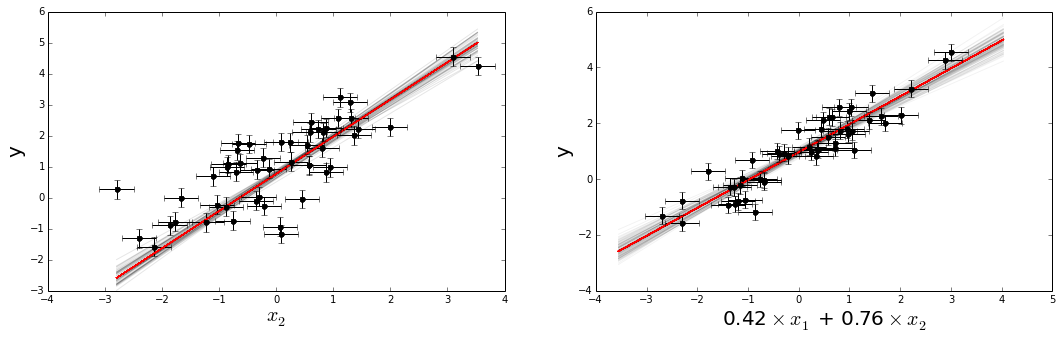

In [22]:
x_2_lims = np.array([min(x_2_obs), max(x_2_obs)])
x_1_lims = np.array([min(x_1_obs), max(x_1_obs)])

median_alpha = medians[0]
median_beta1 = medians[1]
median_beta2 = medians[2]
median_sigma_squared = medians[3]

median_alpha_string = '%.2f' % median_alpha
median_beta1_string = '%.2f' % median_beta1
median_beta2_string = '%.2f' % median_beta2
median_sigma_squared_string = '%.2f' % median_sigma_squared


combined_independent_variables_obs = median_beta1*x_1_obs + median_beta2*x_2_obs

combined_independent_variables_model = median_beta1*x_1_lims + median_beta2*x_2_lims
 
best_fit_model = median_alpha + median_beta1*x_1_lims + median_beta2*x_2_lims

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
for alpha, beta1, beta2, sigma in sampler.flatchain[np.random.randint(len(sampler.flatchain), size=50)]:
    plt.plot(x_2_lims, alpha + beta1*x_1_lims+beta2*x_2_lims, color="k", alpha=0.1)
    plt.plot(x_2_lims, best_fit_model, 'r-')
plt.errorbar(x_2_obs, y_obs, yerr=sigma_y, fmt=".k", markersize=10)
plt.errorbar(x_2_obs, y_obs, xerr=sigma_x_1, fmt=".k", markersize=10)
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"y", fontsize=20)


plt.subplot(1,2,2)
for alpha, beta1, beta2, sigma in sampler.flatchain[np.random.randint(len(sampler.flatchain), size=100)]:
    plt.plot(combined_independent_variables_model, alpha + beta1*x_1_lims+beta2*x_2_lims, color="k", alpha=0.05)
    plt.plot(combined_independent_variables_model, best_fit_model, 'r-')
plt.errorbar(combined_independent_variables_obs, y_obs, yerr=sigma_y, fmt=".k", markersize=10)
plt.errorbar(combined_independent_variables_obs, y_obs, xerr=beta1*sigma_x_1 + beta2*sigma_x_2, fmt=".k", markersize=10)
plt.xlabel(median_beta1_string + r"$\times$ $x_1$ + " + median_beta2_string + r"$\times$ $x_2$", fontsize=20)
plt.ylabel(r"y", fontsize=20)

plt.show()

Plot the fits again, but this time, use a shaded grey region to define the 90% confidence region

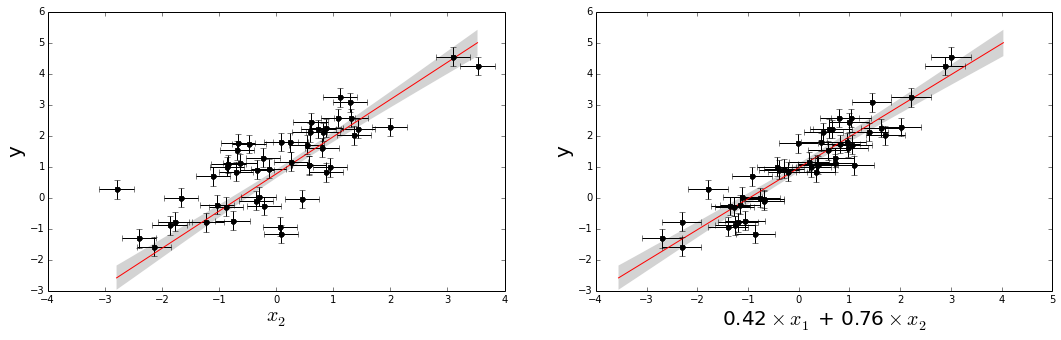

In [23]:
x_2_lims = np.array([min(x_2_obs), max(x_2_obs)])
x_1_lims = np.array([min(x_1_obs), max(x_1_obs)])

combined_independent_variables_obs = median_beta1*x_1_obs + median_beta2*x_2_obs

combined_independent_variables_model = median_beta1*x_1_lims + median_beta2*x_2_lims
 
best_fit_model = median_alpha + median_beta1*x_1_lims + median_beta2*x_2_lims

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)

plt.plot(x_2_lims, best_fit_model, 'r-')
plt.errorbar(x_2_obs, y_obs, yerr=sigma_y, fmt=".k", markersize=10)
plt.errorbar(x_2_obs, y_obs, xerr=sigma_x_2, fmt=".k", markersize=10)
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel("y", fontsize=20)

# Now plot the (shaded) uncertainty region around the best fit line

npoints = 100

predX1 = np.linspace(x_1_obs.min(), x_1_obs.max(), npoints)
predX2 = np.linspace(x_2_obs.min(), x_2_obs.max(), npoints)

nsamples = len(sampler.flatchain[:,1])

predY = np.zeros((npoints,nsamples))

for i in range(nsamples):
    alpha, beta1, beta2, sigma = sampler.flatchain[i, :] 
    predY[:,i] = alpha + beta1*predX1 + beta2*predX2

# Make it plot the 90% confidence region (i.e. from 5th - 95th percentile)
upper = np.percentile(predY, 5.0, axis=1)
lower = np.percentile(predY, 95.0, axis=1)
plt.fill_between(predX2, lower, upper, facecolor = 'lightgrey', edgecolor = 'none')


plt.subplot(1,2,2)
plt.plot(combined_independent_variables_model, best_fit_model, 'r-')
plt.errorbar(combined_independent_variables_obs, y_obs, yerr=sigma_y, fmt=".k", markersize=10)
plt.errorbar(combined_independent_variables_obs, y_obs, xerr=beta1*sigma_x_1 + beta2*sigma_x_2, fmt=".k", markersize=10)
plt.xlabel(median_beta1_string + r"$\times$ $x_1$ + " + median_beta2_string + r"$\times$ $x_2$", fontsize=20)
plt.ylabel("y", fontsize=20)

plt.fill_between(median_beta1*predX1 + median_beta2*predX2, lower, upper, facecolor = 'lightgrey', edgecolor = 'none')

plt.show()

This Notebook takes inspiration from other people's work, particularly this blog post/notebook by Chris Burns http://users.obs.carnegiescience.edu/cburns/ipynbs/Emcee.html